In [ ]:
! ls -rlta

In [1]:
# For SQL-type queries (Spark)
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# For regression and other possible ML tools (Spark)
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics


# Important for managing features  (Spark)
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler

# For displaying and other related IPython tools...
from IPython.display import display
from IPython.html.widgets import interact

# Typycal Python tools
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# We now create a SQL DataFrame, this entity is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in Python, but with richer optimizations under the hood. We will utilize the recently created Spark RDD and use the Spark SQL context to create the desired data frame,

# We first create function that will allow to parse a record of our RDD into the desired format. As a reference we take a look at features_names and feature_example we just created above

def parse(r):
    try:
        x=Row(Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          CRSDepTime=int(r[5]),\
          DepDelay=int(float(r[15])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18]))) 
    except:
        x=None  
    return x

# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h
# register as a UDF 
f = udf(hour_ex, IntegerType())

In [3]:
def prepFlightDelay(airfile, orgn):
    textFile = sc.textFile(airfile)
    textFileRDD = textFile.map(lambda x: x.split(','))
    header = textFileRDD.first()
    textRDD = textFileRDD.filter(lambda r: r != header)
    rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
    airline_df = sqlContext.createDataFrame(rowRDD)
    airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
    airline_df.registerTempTable("airlineDF")
    airline_df_orgn = airline_df.filter((col("Origin") == orgn))
    airline_df_orgn_15 = airline_df_orgn.withColumn('DepDelayed', (airline_df_orgn['DepDelay']>15).cast(DoubleType()))
    return airline_df_orgn_15

In [4]:
def prepWeather(wfile):
    df = sqlContext.read.csv(wfile, header=True)
    df_parse = df.drop('STATION', 'NAME')
    df_parse1 = df_parse.withColumn("DATE", regexp_replace('DATE', '/', '-'))
    df_parse2 = df_parse1.withColumn("AWND", df_parse1["AWND"].cast("Int"))
    df_parse3 = df_parse2.withColumn("PRCP", df_parse2["PRCP"].cast("Int"))
    df_parse4 = df_parse3.withColumn("SNOW", df_parse3["SNOW"].cast("Int"))
    df_parse5 = df_parse4.withColumn("TMAX", df_parse4["TMAX"].cast("Int"))
    df_parse6 = df_parse5.withColumn("TMIN", df_parse5["TMIN"].cast("Int"))
    df_month = df_parse6.withColumn("Month", split(df_parse6.DATE, "-")[0].cast("Int"))
    df_day = df_month.withColumn("DayofMonth", split(df_month.DATE, "-")[1].cast("Int"))
    df_weather = df_day.drop('DATE')
    return df_weather

In [5]:
def preprocessing (airfile,wfile,org):
    airline_delay_org = prepFlightDelay(airfile,org)
    airlinedelay_pd_df = airline_delay_org.toPandas()
    df_weather = prepWeather(wfile)
    weather_pd_df = df_weather.toPandas()
    airdelay_weather = pd.merge(airlinedelay_pd_df,weather_pd_df,how='right', left_on=['Month','DayofMonth'], right_on = ['Month','DayofMonth'])
    airdelay_pred = sqlContext.createDataFrame(airdelay_weather)
    return airdelay_pred

In [6]:
flight_delay_2007 = preprocessing ("2007.csv","2007-ord-weather-data.csv","ORD")

In [7]:
flight_delay_2007.printSchema()

root
 |-- CRSDepTime: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- hour: long (nullable = true)
 |-- DepDelayed: double (nullable = true)
 |-- AWND: long (nullable = true)
 |-- PRCP: long (nullable = true)
 |-- SNOW: long (nullable = true)
 |-- TMAX: long (nullable = true)
 |-- TMIN: long (nullable = true)



In [8]:
flight_delay_2007.dtypes

[('CRSDepTime', 'bigint'),
 ('DayOfWeek', 'bigint'),
 ('DayofMonth', 'bigint'),
 ('DepDelay', 'bigint'),
 ('Dest', 'string'),
 ('Distance', 'bigint'),
 ('Month', 'bigint'),
 ('Origin', 'string'),
 ('hour', 'bigint'),
 ('DepDelayed', 'double'),
 ('AWND', 'bigint'),
 ('PRCP', 'bigint'),
 ('SNOW', 'bigint'),
 ('TMAX', 'bigint'),
 ('TMIN', 'bigint')]

In [9]:
flight_delay_2008 = preprocessing ("2008.csv","2008-ord-weather-data.csv","ORD")

In [10]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, OneHotEncoder, StandardScaler, StandardScalerModel, VectorSlicer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline, Model

In [13]:
df_2007 = flight_delay_2007.toPandas()
df_2008 = flight_delay_2008.toPandas()

In [54]:
X_train = df_2007[["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN","Dest"]]
X_test = df_2008[["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN","Dest"]]

In [55]:
X_train.head(3)

,hour,DayOfWeek,DayofMonth,DepDelay,Distance,Month,AWND,PRCP,SNOW,TMAX,TMIN,Dest
0,11,4,25,-8,719,1,9,0,0,24,15,EWR
1,18,4,25,-3,719,1,9,0,0,24,15,EWR
2,12,4,25,16,719,1,9,0,0,24,15,EWR


In [56]:
X_test.head(3)

,hour,DayOfWeek,DayofMonth,DepDelay,Distance,Month,AWND,PRCP,SNOW,TMAX,TMIN,Dest
0,16,2,8,71,719,1,13,0,0,56,37,EWR
1,17,2,8,117,316,1,13,0,0,56,37,CLE
2,8,2,8,28,719,1,13,0,0,56,37,EWR


In [58]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode the label state
#labelEncoder_X = LabelEncoder()
#X_test["Dest"] = labelEncoder_X.fit_transform(X_test["Dest"])

# Encode the last column of categorical value
onehotencoder_x = OneHotEncoder(categorical_features = X_test["Dest"])
X_test = onehotencoder_x.fit_transform(X_test).toarray()

IndexError: index 47 is out of bounds for axis 1 with size 12

In [34]:
y_train = df_2007[["DepDelayed"]]
y_test = df_2008[["DepDelayed"]]

In [35]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [36]:
# Fitting Logistic regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# Predict the test_set results
y_predict = classifier.predict(X_test)
y_predict

array([1., 1., 1., ..., 1., 1., 1.])

In [38]:
# Evaluate the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_results = confusion_matrix(y_test,y_predict)

In [39]:
print ("The True Positive of Number of People Purchased is {}".format(cm_results[0][0]))

The True Positive of Number of People Purchased is 242571


In [41]:


#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

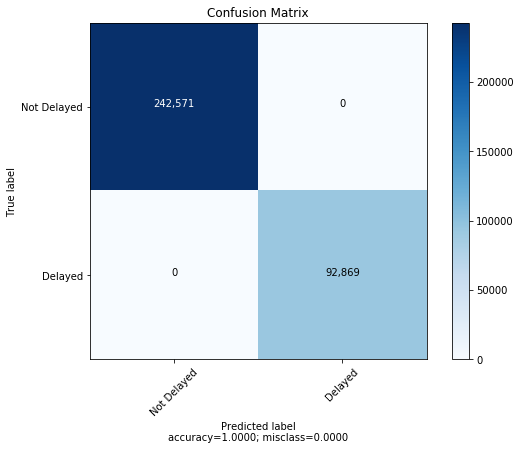

In [43]:
plot_confusion_matrix(cm           = cm_results, 
                      normalize    = False,
                      target_names = ['Not Delayed', 'Delayed'],
                      title        = "Confusion Matrix")

In [ ]:
def ml_preprocess(dataset):
    pipeline_stages = [] # stages in our Pipeline
    
    
    # Transform all features into a vector using VectorAssembler
    inputColumns = ["hour","DayOfWeek","DayofMonth","DepDelay","Distance","Month","AWND","PRCP","SNOW","TMAX","TMIN"]
    assembler = VectorAssembler(inputCols=inputColumns, outputCol="features")
    pipeline_stages += [assembler]
    
    # Convert label into label indices using the StringIndexer
    predict_label = StringIndexer(inputCol="DepDelayed", outputCol="label")
    pipeline_stages += [predict_label]

    
    # Create a Pipeline.
    pipeline = Pipeline(stages=pipeline_stages)

    # Run the feature transformations.
    #  - fit() computes feature statistics as needed.
    #  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(dataset)
    processed_dataset = pipelineModel.transform(dataset)
    
    return processed_dataset

In [ ]:
training_data_2007 = ml_preprocess(flight_delay_2007)
testing_data_2008 = ml_preprocess(flight_delay_2008)

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(training_data_2007)

In [ ]:
lrPredictions = lrModel.transform(testing_data_2008)

In [ ]:
lrPredictions.select("prediction", "label", "features").show(20)

In [ ]:
training_data_2007.printSchema()

In [ ]:
#%spark2.pyspark
##### We can obtain the coefficients by using LogisticRegressionModel’s attributes.
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Training Data Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
# Precision and Recall

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
lrPredictions.printSchema()
lr_prediction_df = lrPredictions.toPandas()

In [ ]:
lr_prediction_df.head()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator_lr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator_lr.evaluate(lrPredictions)

In [ ]:
a = lr_prediction_df.count()[0]

In [ ]:
b = lr_prediction_df['label'].sum()

In [ ]:
c =lr_prediction_df['prediction'].sum()

In [ ]:
fig, ax = plt.subplots()
ax.plot(a, b)
ax.plot(a, c)
ax.set_title('Simple plot')